# Project II (Newton vs the machine) - Solving the chaotic three-body problem using deep neural networks as part of Chalmers TIF285

by Matthias Hübl & Linus Stach

---

Models:

    model: Our trained model (LFD model)
    pre_trained_model: Model from Newton vs the machine (https://arxiv.org/pdf/1910.07291.pdf)
    model_Eloss: Our trained model with custom loss function that takes energy conservation into account

## Imports, Inits, Helper functions etc.

Import Numpy, Tensorflow, Keras, Matplotlib and Sklearn

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import time as t
from datetime import datetime

# Additional imports
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, initializers

2023-10-21 13:59:01.271647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 13:59:02.554242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 13:59:05.152879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Test for GPU availibility

In [2]:
devices = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", devices)

Available GPUs:  []


Define constants and hyperparameters

In [3]:
BATCH_SIZE = 1000
SEED = 2023
EPOCHS = 100 # 50
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
Ncircle = 1000 # 1000
train = False
trainE = False
latex_textwidth = 6.69292

In [4]:
# plt.rcParams['axes.grid'] = True
# plt.rcParams['figure.figsize'] = (columnwidth_inch,columnwidth_inch/1.5275)
plt.rcParams['figure.dpi'] = 196
plt.rcParams.update({'font.serif':'Computer Modern Roman'})
plt.rcParams['font.size'] = 11

Helper functions

In [5]:
def get_data(data, idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """

    x = data[idx, :, [0,3,4]].T
    y = data[idx, :, 1:5]

    assert np.all(y[0,:2] == [1.,0.]),  "first particle should start at (1,0)"
    return x, y

In [6]:
def get_trajectories(pred):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    p1 = pred[:, :2]
    p2 = pred[:, 2:]
    p3 = -p1-p2
    return p1, p2, p3

In [7]:
def plot_trajectories(p1, p2, p3, label, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
        
    Returns:
        ax: Axes object
    """
    
    traces = [p1, p2, p3]
    colors = ["red","green","blue"]

    if ax is None:
        fig, ax = plt.subplots()
    for color, trace in zip(colors, traces):
        ax.plot(trace[:,0],trace[:,1], color=color, **kwargs)
        ax.scatter(trace[0,0], trace[0,1], s=100, color=color, zorder=5)

    ticks = [-1, -0.5, 0, 0.5, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    
    return ax

## Task 1

Download and load the pre-trained ANN from the paper (see below) and construct your own ANN using the provided data. Compare the complexity (number of trainable parameters) in the pre-trained versus your own ANN.

* First download and load the data set and the ANN from the paper (both available on the Canvas course page. Navigate to Files > Project2; see hint below)

In [8]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(data.shape)

(9000, 1000, 9)


Dataset shape:

Shape: (9000, 1000, 9)
    
- 9000 samples
- 1000 time steps [0, 0.003, ..., 3.9]
- 9: $[t, x_1, y_1, x_2, y_2, v_{x,1}, v_{y,1}, v_{x,2}, v_{y,2}]$

### Data Preprocessing

In [9]:
# extract relevant data
x = data[:, :, [0,3,4]] # t, x2, y2
y = data[:, :, 1:5] # x1, y1, x2, y2
y_v = data[:, :, 5:]

# create input for NN prediction
a = np.repeat(x[:,0,[1,2]][:, np.newaxis, :], 1000, axis=1) # repetition of (x2, y2) 1000 times for each trajectory
b = np.expand_dims(x[:,:,0], 2) # timestamps in the correct shape
x = np.concatenate((b,a), axis=2) # concatenation with the time stamps and the starting position of particle 2 for each trajectory

# As mentioned, some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). 
# Check the data to find those trajectories and remove them before training your model.
zero_trajectories = np.all(y[:,-1,:] == np.zeros(4), axis=1) # all trajectories that end at (0,0,0,0)
x = x[np.invert(zero_trajectories),:,:]
y = y[np.invert(zero_trajectories),:,:]
y_v = y_v[np.invert(zero_trajectories),:,:]

print(x.shape)
print(y.shape)
print(y_v.shape)

(7623, 1000, 3)
(7623, 1000, 4)
(7623, 1000, 4)


In [10]:
# Perform train, validation, test split [0.81,0.09,0.1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SPLIT, random_state=SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=SEED)

X_v_train, _, y_v_train, y_v_test = train_test_split(x, y_v, test_size=TEST_SPLIT, random_state=SEED)
_, _, y_v_train, y_v_validation = train_test_split(X_v_train, y_v_train, test_size=VALIDATION_SPLIT, random_state=SEED)

# flatten an axis to make trajectories consecutive
X_train_single = X_train.reshape(1000*X_train.shape[0],3) # reshape from (Ntrajectories, Ntimes, 3) to (Ntrajectories*Ntimes, 3)
y_train_single = y_train.reshape(1000*y_train.shape[0],4)

X_test_single = X_test.reshape(1000*X_test.shape[0],3)
y_test_single = y_test.reshape(1000*y_test.shape[0],4)

X_validation_single = X_validation.reshape(1000*X_validation.shape[0],3)
y_validation_single = y_validation.reshape(1000*y_validation.shape[0],4)

# To tensor and batch
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single)).batch(BATCH_SIZE)
dataset_validation = tf.data.Dataset.from_tensor_slices((X_validation_single, y_validation_single)).batch(BATCH_SIZE)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_single, y_test_single)).batch(BATCH_SIZE)

2023-10-21 13:59:51.453807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 148176000 exceeds 10% of free system memory.
2023-10-21 13:59:52.896638: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 197568000 exceeds 10% of free system memory.


For test purposes:

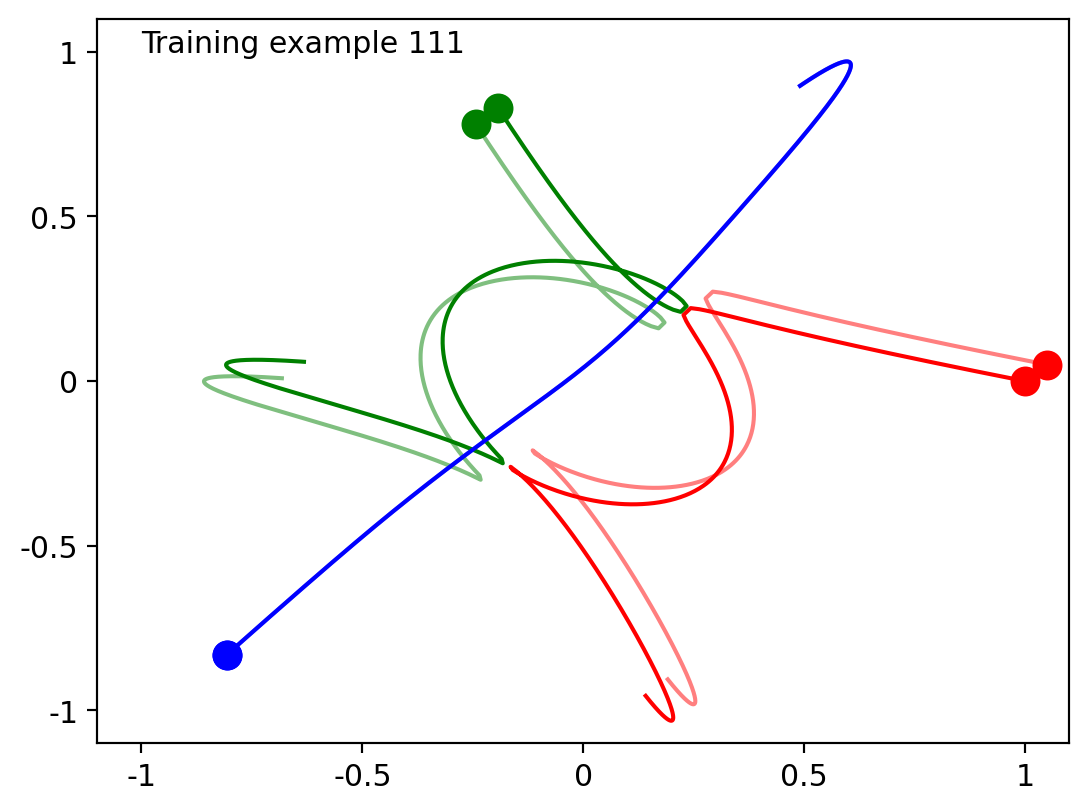

In [11]:
idx = 111
x_instance, y_instance = get_data(data=data, idx=idx)
p1, p2, p3 = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))

# Plot once for ground truth: y
plot_trajectories(p1+0.05, p2-0.05, p3, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1, p2, p3, ax=ax, label=idx);

### Define own model, loss and optimizer

Design decisions

    1. Weight initialization is a crucial component. For dense layers with relu activation I suggest to use the Kaiming He initialization technique proposed in "Surpassing Human-Level Performance on ImageNet Classification" (ttps://arxiv.org/pdf/1502.01852.pdf)

In [12]:
if train:
    # Define Sequential MLP network with 6 layers à 128 neurons and an output layer
    model = models.Sequential([
        layers.InputLayer(3),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(4)])                 
    
    # Define Adam optimizer
    #optimizer = optimizers.Adam(0.001, 0.5, 0.5)
    optimizer = optimizers.Adam()
    
    # Define MAE loss
    loss = losses.MeanAbsoluteError()
    
    # Compile our model
    model.compile(optimizer=optimizer, loss=loss)

 or load an existing model

In [13]:
if not(train):
    # Insert the name of the model you want to load
    model_name = "1910_2119_final"
    model = keras.models.load_model(f"./models/NN_project2_{model_name}.keras")

### Get model summary

In [14]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               512       
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)              

### Fit our model

In [15]:
# If no improvement in the validation loss is seen for 2 epochs, the lerning rate is reduced by a factor of 0.5
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# stops the training when the validation loss has stopped improving for 4 epochs
callback_lr = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

### Train and save the model

In [16]:
%%time
if train:
    history = model.fit(dataset_train, 
                        epochs=EPOCHS, 
                        validation_data = dataset_validation,
                        callbacks=[reduce_lr,callback_lr],
                        )
    now = datetime.now()
    tn = now.strftime('%d%m_%H%M')
    tf.keras.models.save_model(model, f"./models/NN_project2_{tn}.keras")
    np.save(f"./history/train_{tn}", arr=history.history["loss"])
    np.save(f"./history/val_{tn}", arr=history.history["val_loss"])

CPU times: user 4 µs, sys: 6 µs, total: 10 µs
Wall time: 20 µs


### Test our model

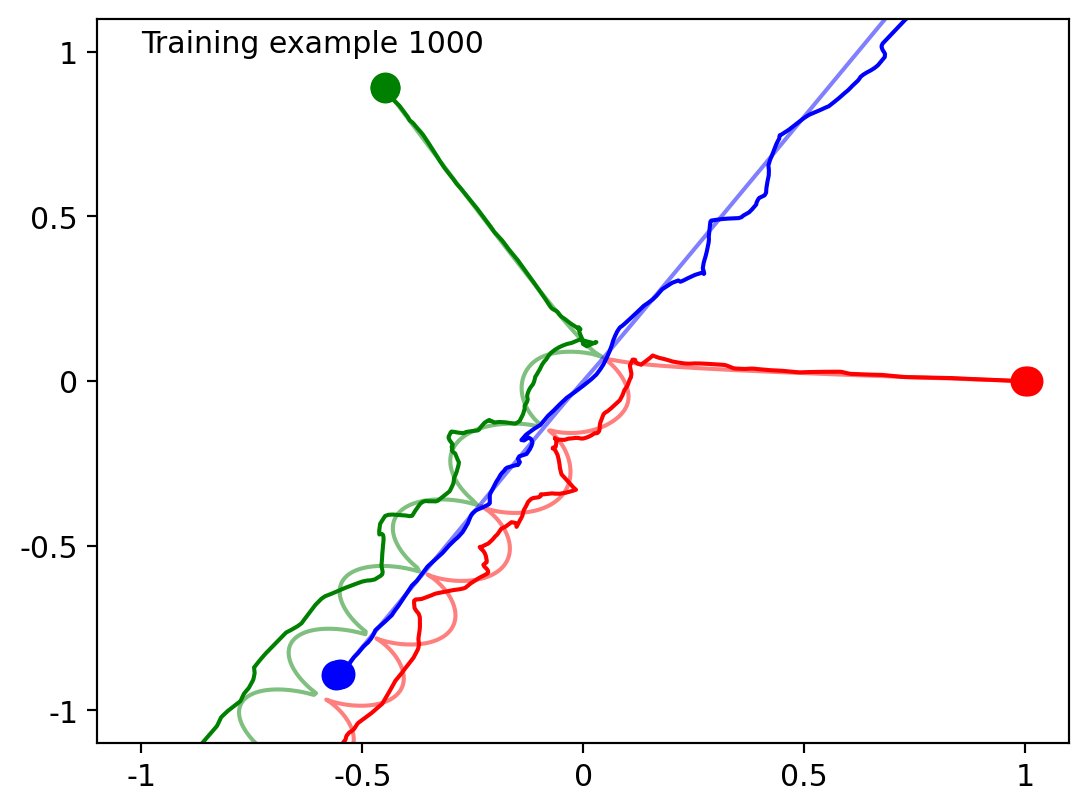

In [17]:
idx = 1000
input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
yhat_pre_trained = model.predict(input_data, verbose=False)

y_instance = y_train[idx,:,:]

p1_hat, p2_hat, p3_hat = get_trajectories(yhat_pre_trained)
p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))

# Plot once for ground truth: y
plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx);

### Get the provided model

In [18]:
pre_trained_model = keras.models.load_model("Breen_NN_project2.h5")
pre_trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512 

Test provided model

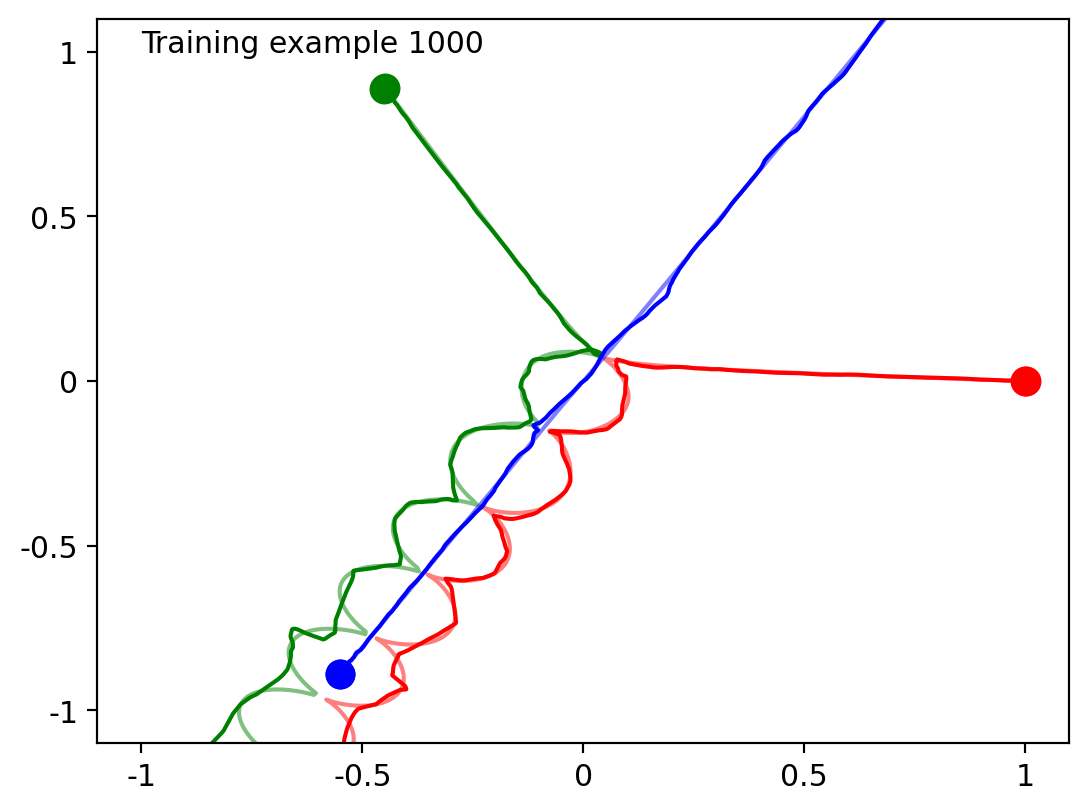

In [19]:
idx = 1000
input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
yhat_pre_trained = pre_trained_model.predict(input_data, verbose=False)

y_instance = y_train[idx,:,:]

p1_hat, p2_hat, p3_hat = get_trajectories(yhat_pre_trained)
p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))

# Plot once for ground truth: y
plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx);

## Task 2

Show the Mean Absolute Error (MAE) vs epoch from the training of your own ANN (as in Fig. 3 of the paper). I.e. you should show both the MAE metric on the training and the validation data.

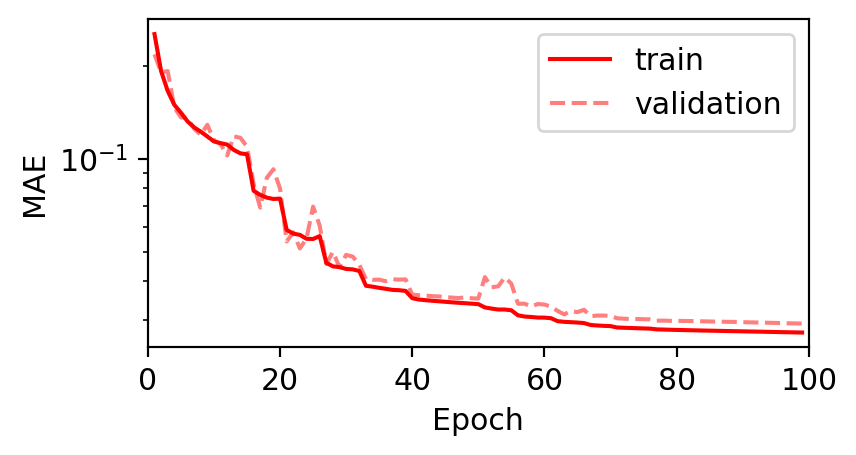

In [23]:
# generate synthetic data

if train:
    train_loss = list(history.history["loss"])
    validation_loss = list(history.history["val_loss"])
else:
    train_loss = np.load(f'./history/train_{model_name}.npy')
    validation_loss = np.load(f'./history/val_{model_name}.npy')

# --- plot

fig, ax = plt.subplots(1,1, figsize=(.65*latex_textwidth, .65*latex_textwidth/2))
# fig, ax = plt.subplots(1,1, figsize=(16, 8))

xepochs = np.arange(1,len(train_loss)+1,1)

ax.plot(xepochs, train_loss, color="red", ls="-", label="train")
ax.plot(xepochs, validation_loss, color="red", ls="--", alpha=0.5, label="validation")
ax.set_yscale('log')
ax.set_xlim([1,len(train_loss)])
ax.set_xticks(np.arange(0,len(train_loss)+2,(len(train_loss)+1)/5))
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
# ax.set_title("Learning curve of ANN")
ax.legend()

fig.savefig("./plots/learning_curve.png", bbox_inches='tight', dpi=400)

plt.show()

## Task 3

Check the accuracy of the pre-trained ANN by showing some trajectories and the ANN prediction as in Fig. 4 of the paper. Add also the trajectory of your ANN and comment on its performance. (Note that you should not expect your own ANN to perform as well as the pre-trained one. In addition, the trajectories that are shown in the paper seem to be ones for which the model works very well).

In [40]:
instances = [1,3,2,4]
# instances = [1000,2,111,50]

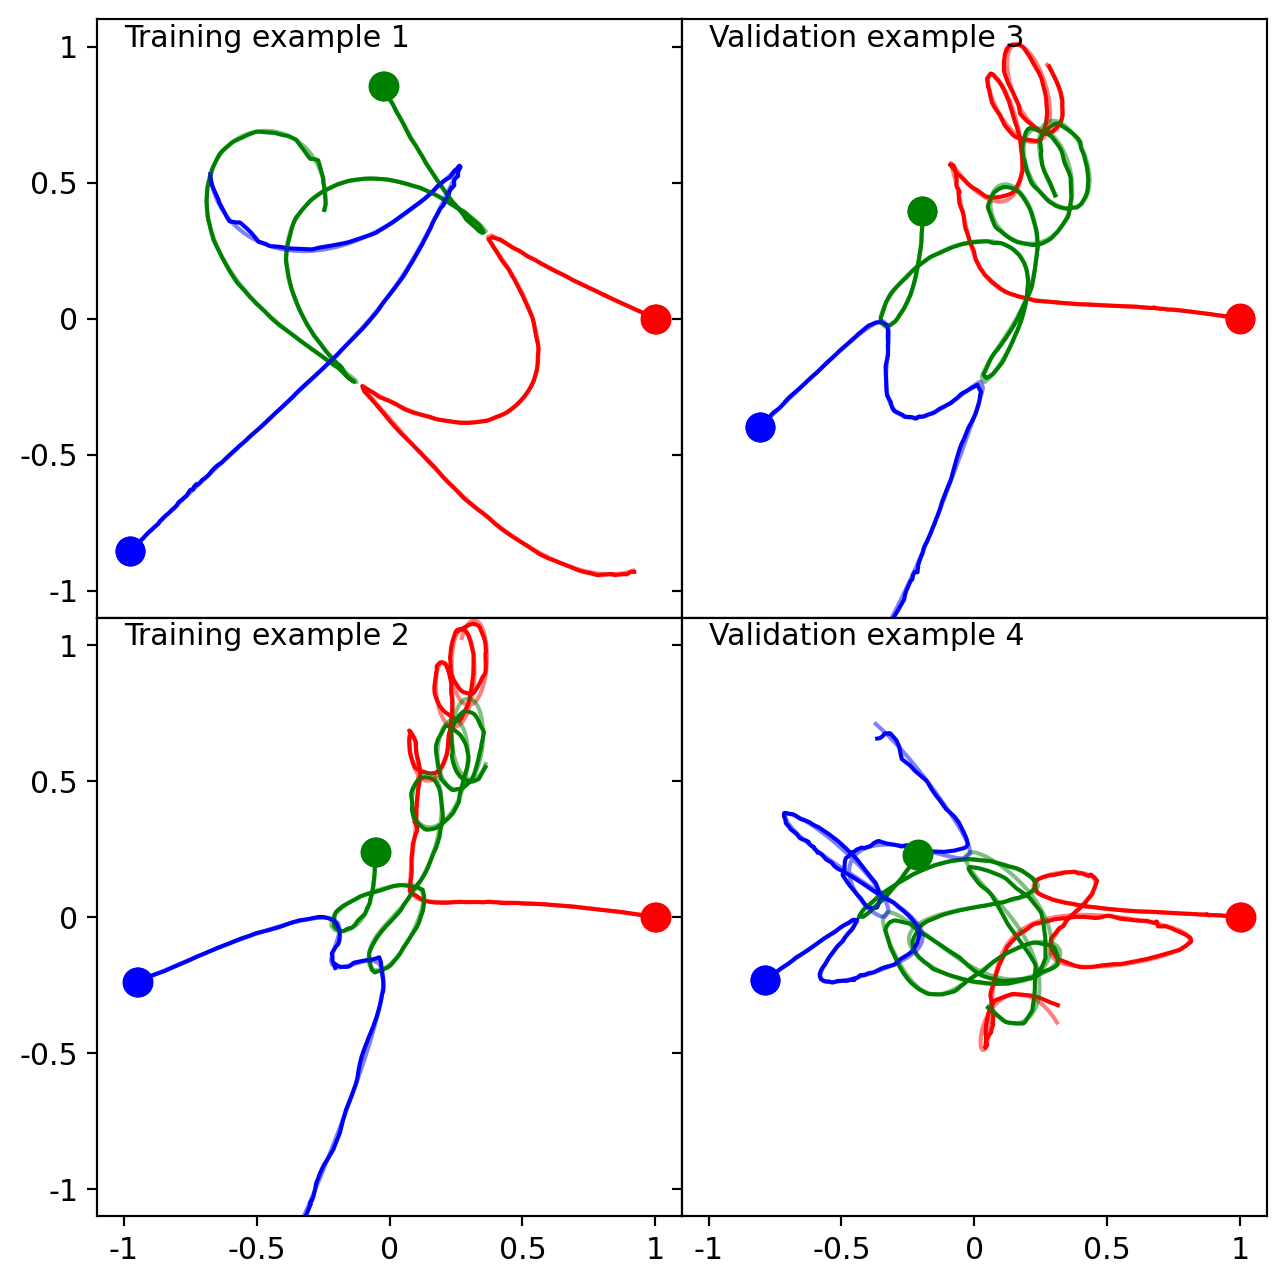

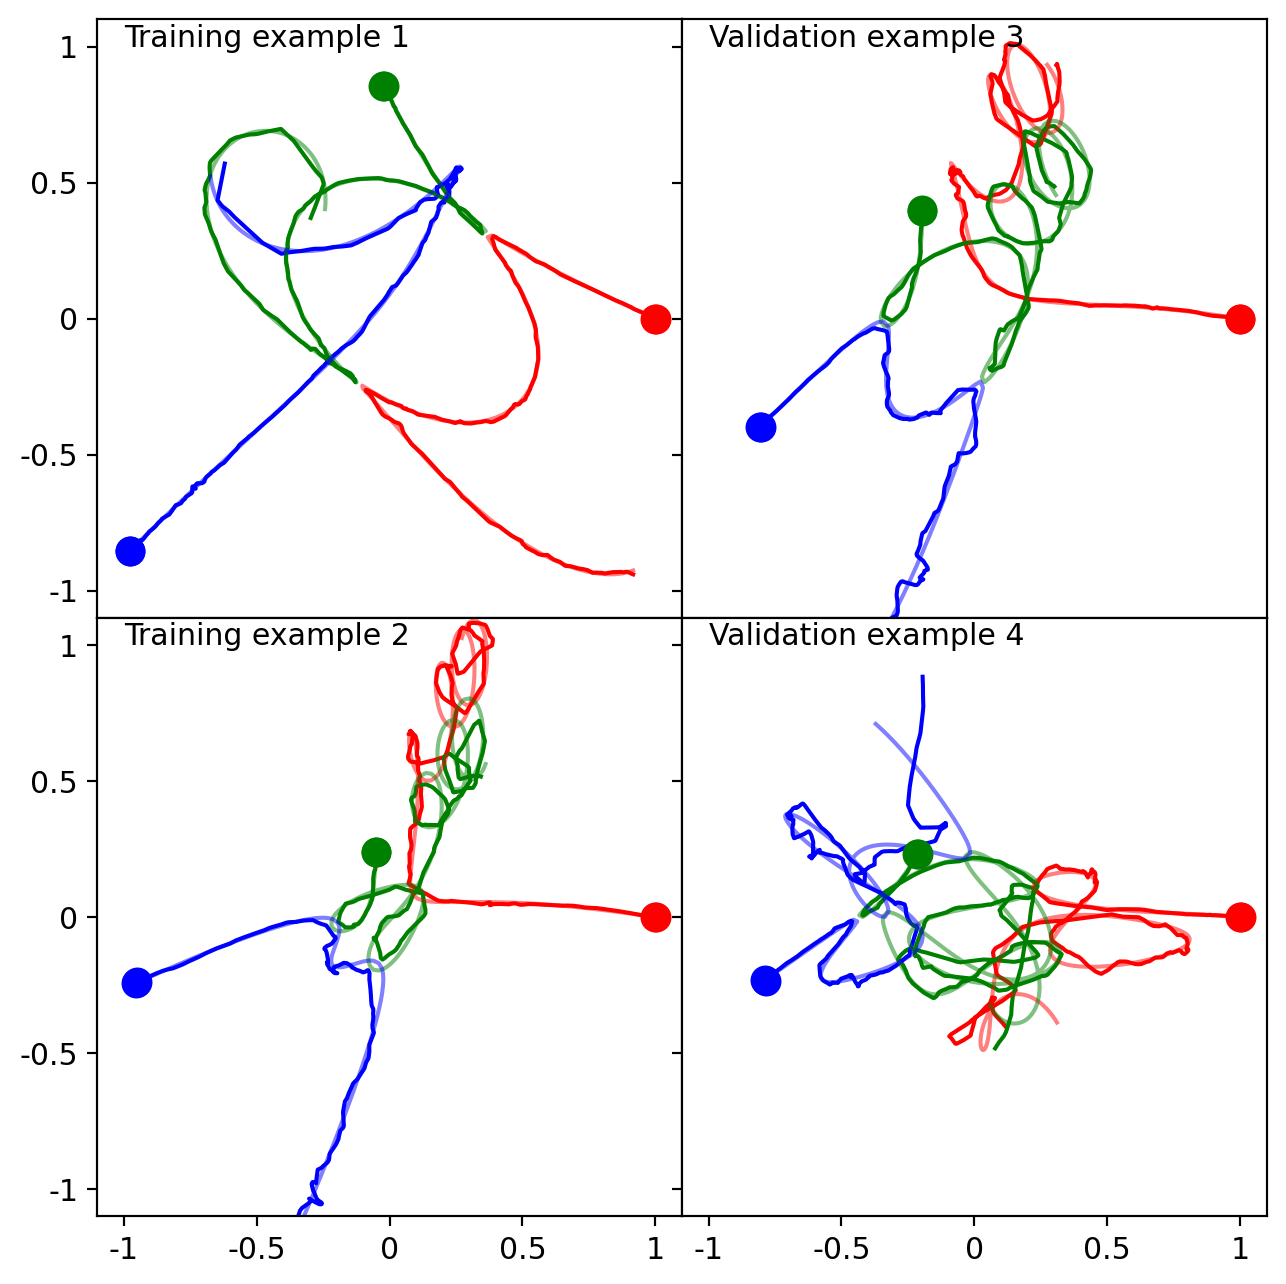

In [22]:

for mm, title in zip([pre_trained_model, model], ["Pre-trained Model", "Our Model"]):
    fig, axs = plt.subplots(2,2, figsize=(latex_textwidth,latex_textwidth), sharex=True, sharey=True)
    for idx, ax, settype in zip(instances, axs.flatten(), ["train", "validation", "train", "validation"]):
        if settype=="train":
            input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
            ax.annotate(f"Training example {idx}", xy=(-1, 1))
            y_instance = y_train[idx,:,:]
        elif settype=="validation": 
            input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
            ax.annotate(f"Validation example {idx}", xy=(-1, 1))
            y_instance = y_validation[idx,:,:]
    
        yhat = mm.predict(input_data, verbose=False)
    
        p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)
    
        plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx)
        plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
    # fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    if title=="Pre-trained Model":
        fig.savefig("./plots/trajectory_paper", dpi=400)
    elif title=="Our Model":
        fig.savefig("./plots/trajectory_lfd", dpi=400)

### Compare model loss

In [23]:
print("Train loss LFD model: ", model.evaluate(dataset_train))
print("Test loss LFD model: ", model.evaluate(dataset_test))
print("Loss Paper model: ", pre_trained_model.evaluate(dataset_train)[0])

2023-10-21 11:16:31.233480: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 148176000 exceeds 10% of free system memory.
2023-10-21 11:16:31.396148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 197568000 exceeds 10% of free system memory.


6174/6174 [==============================] - 103s 17ms/step - loss: 0.0267
Train loss LFD model:  0.026678767055273056
763/763 [==============================] - 9s 11ms/step - loss: 0.0273
Test loss LFD model:  0.027292024344205856
6174/6174 [==============================] - 72s 12ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 165.7011 - mean_squared_error: 0.0161
Loss Paper model:  0.01664922758936882


## Task 4

Check the computational cost of making a prediction with the ANN. You will find that it is much shorter than the numerical integration performed by `Brutus` (which according to the reference takes minutes to hours for finding a trajectory).

In [24]:
Nloops = 100
times = np.zeros(Nloops)
idx=4
# Do 100 turnes of sampling + measuring inference time 
# Take mean afterwards
for i in range(100):
    input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
    start = t.time()
    model.predict(input_data, verbose=False)
    end = t.time()
    diff = end - start
    times[i] = (diff)
    idx+=1
print(f"{np.mean(times)*1000:.1f} ms +- {np.std(times, ddof=1)*1000:.1f} ms per run (mean +- std. dev. of {Nloops} runs)")

150.4 ms +- 12.2 ms per run (mean +- std. dev. of 100 runs)


In [25]:
%%timeit
idx=4
input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
model.predict(input_data, verbose=False);

149 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


    Assume a computation time between 1 minute and 10 hours for one prediction with Brutus.

    * Computation time Brutus: 60sec - 36000sec
    * Computation time NN: ~ 0.17sec 

    => We are roughly between 350 and 216,000 times faster

## Task 5

Having access to these ANN emulators you can explore the chaotic aspect of this motion by creating a hundred different trajectories from a slightly disturbed initial condition. Try to reproduce Fig. 5 in the paper (both with the pre-trained and your own ANN).

In [41]:
def f_rad(N, center=(-0.2, 0.3), rad=0.01):
    """
    Creates N random inital positions on a circle of radius rad centered at center.
    
    Args:
        N (int): Number of points
        center (array): Default (-0.2, 0.3), center coordinates (x,y) of the circle
        rad (float): Default 0.01, radius of the circle
        
    Returns:
        points (array): array of shape (N,2) containing random points on the circle
    """
    theta = np.random.rand(N)*2*np.pi
    x = center[0] + rad * np.cos(theta)
    y = center[1] + rad * np.sin(theta)
    return np.vstack((x,y)).T


# create initial positions on the circle
N = Ncircle
data_circ = f_rad(N)
# print(data_circ.shape)

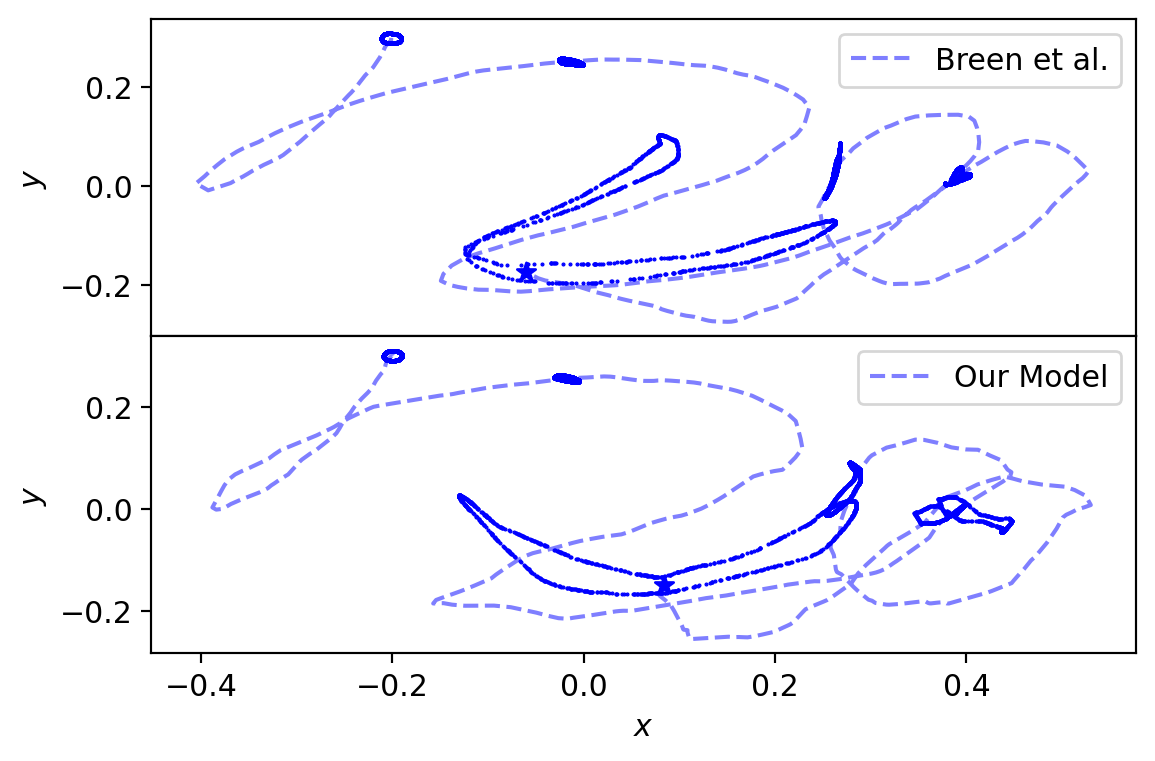

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(0.9*latex_textwidth,0.9*latex_textwidth*2/3), sharex=True)
for mm, title, ax in zip([pre_trained_model, model], ["Breen et al.", "Our Model"], axs):

    # plot the central trajectory
    center = np.array([-0.2,0.3])
    input_data_center = np.hstack((X_train[0,:,0].reshape(1000,1),np.full((1000,2),center)))
    
    yhat = mm.predict(input_data_center, verbose=False)

    idcs = np.searchsorted(X_train[0,:,0], [0.0, 0.95, 1.9, 2.95, 3.8]) # idcs at which trajectories are plotted

    p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
    trace = p2_hat[:idcs[-1]]
    
    ax.plot(trace[:,0],trace[:,1], color='b', ls='--', alpha=0.5, label=title) # dashed line
    ax.scatter(trace[-1,0], trace[-1,1], s=50, color='b', marker='*', zorder=5) # end point

    for start_pos in data_circ:
        input_data = np.hstack((X_train[0,:,0].reshape(1000,1),np.full((1000,2),start_pos)))
    
        yhat = mm.predict(input_data, verbose=False)
        
        p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
        trace = p2_hat[idcs]
        
        ax.plot(trace[:,0],trace[:,1], color='b', marker='.', ms=1, lw=0)
    ax.legend()
    ax.set_ylabel("$y$")
axs[1].set_xlabel("$x$")
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig("./plots/variation.png", dpi=400)

## Extra Task

* In order to construct a `tensorflow` custom loss you will need `@tf.function()` versions of the same helper functions. Within these you can only use `tensforflow` methods such as: `tf.concat()` and `tf.math.sqrt()` (i.e., `numpy` methods cannot be used for these functions). 
* You can define a custom loss function that assumes a batch size that is equal to the number of time steps in a trajectory. You should also make sure that the data is not shuffled so that a batch always corresponds to a trajectory. Then you can use a global time array to be used to extract velocities and therefore kinetic energies.
* See a suggested structure of the custom loss below. You might get problems with very large kinetic and potential energies for trajectories with close encounters. A suggestion is to clip very large values of `energy_error` in the return statement of the custom energy loss by `tf.clip_by_value(energy_error, -1e6, 1e6)`. 
* The custom loss is then used in `model.compile()` via the argument `loss=custom_energy_loss`.

TODO: Check for the conservation of energy in: (i) the data generated by Brutus (note that the velocities are given in the last few columns of the data file); (ii) the pre-trained model from the paper; (iii) your ANN model.

Helper function

In [24]:
@tf.function()
def tf_ediff1d(a):
    """
    TensorFlow equivalent of 1D difference.
    
    Args:
        a (array): A TensorFlow array of dimension (N, 1)
        
    Returns:
        diff (array): An array which gives the difference of successive elements of a.
    """
    if a.ndim==2:
        assert a.shape[1]==1,  "Input must have shape (N, 1)"
    
        # Calculate the difference
        diff = a[1:] - a[:-1]
        return diff
    else:
        assert a.ndim==3, "Input must have at most three dimensions"
        assert a.shape[-1]==1, "Last dimension must have size 1"
        diff = a[:,1:] - a[:,:-1]
        return diff

In [25]:
# test functionality 
test_ediff1d = tf.expand_dims(tf.constant([1,1,2,3,5,8,13,21,34]), axis=1)
tf_ediff1d(test_ediff1d)

<tf.Tensor: shape=(8, 1), dtype=int32, numpy=
array([[ 0],
       [ 1],
       [ 1],
       [ 2],
       [ 3],
       [ 5],
       [ 8],
       [13]], dtype=int32)>

* Create a helper function that extracts the velocity at each time step.

Note that the masses start from rest.

In [26]:
@tf.function()
def tf_compute_velocities(t, p):
    """
    Computes the velocities of the particles from the trajectories starting from rest.
    
    Args:
        t (array[float]): An array of shape (N, 1) giving time steps.
        p (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns give the coordinates
                   of the particle.
                             
    Returns:
        v (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns for each array give 
                   the x and y components for the instantaneous velocity
                   of the particle.
    """

    assert t.ndim==2,  "t must have two dimensions"
    assert t.shape[1]==1,  "t must have shape (N, 1)"

    tuple_bool = isinstance(p, tuple)

    if tuple_bool:
        p = tf.convert_to_tensor(p)
    else:
        p = tf.expand_dims(p, axis=0)

    assert p.shape[2]==2, "Must have shape (N,2) or (x,N,2)"

    
    dp1 = tf_ediff1d(tf.expand_dims(p[:,:,0], axis=2))
    dp2 = tf_ediff1d(tf.expand_dims(p[:,:,1], axis=2))

    # --- Logic

    dt = tf_ediff1d(t)

    # calculate velocity dp_i / dt
    v1 = dp1 / dt
    v2 = dp2 / dt

    # Insert 0 velocity for rest
    zero = tf.zeros(shape=(p.shape[0],1,1), dtype=v1.dtype)
    v1 = tf.concat([zero, v1], axis=1)
    v2 = tf.concat([zero, v2], axis=1)

    if tuple_bool:
        return tf.concat([v1,v2], axis=2)
    else:
        return tf.squeeze(tf.concat([v1,v2], axis=2))

In [27]:
test_velocity_time = tf.expand_dims(tf.constant([1,2,3,4,5,6,7,8,9]), axis=1)
test_velocity_p = tf.transpose(tf.constant([[1,1,2,3,5,8,13,21,34],[1,1,2,3,5,8,13,21,34]]))
res = tf_compute_velocities(test_velocity_time, test_velocity_p)
print(res.shape)

test_velocity_time = np.linspace(X_train[0,0,0], X_train[0,-1,0], X_train[0,:,0].size).reshape(-1,1)
res = tf_compute_velocities(test_velocity_time, get_trajectories(y_train[0,:,:]))
print(res.shape)

(9, 2)
(3, 1000, 2)


* Compute the potential energy and the kinetic energy at each time step. The units are chosen such that the total energy is just the sum of these two.

In [28]:
@tf.function()
def tf_compute_kinetic_energy(v):
    """
    Computes the kinetic energy for the given velocity vectors
    
    Args:
        v (array): A (N,2) array of veolcities for N time steps.
        
    Returns:
        ke (array): An array of shape (N, 1) giving the kinetic energies at each time step.
    """
    tuple_bool = (v.ndim==3)

    if tuple_bool:
        v = tf.convert_to_tensor(v)
    else:
        v = tf.expand_dims(v, axis=0)

    assert v.ndim==3, "Must have shape (N,2) or (x,N,2)"
    assert v.shape[2]==2, "Must have shape (N,2) or (x,N,2)"

    half = tf.constant([0.5], dtype=v.dtype)
    v2 = tf.pow(v, 2)  
    v2_summed = tf.reduce_sum(v2, axis=[0,2]) # sum over both coordinates for each particle
    ke = tf.multiply(half,v2_summed)

    assert ke.shape==v.shape[1], "Summed along the wrong axis"
    
    return ke

In [29]:
test_kin = tf.transpose(tf.constant([[1,1,2,3,5],[1,2,3,4,5]], dtype=tf.float32))
print(test_kin.shape)
print(tf_compute_kinetic_energy(test_kin))

(5, 2)
tf.Tensor([ 1.   2.5  6.5 12.5 25. ], shape=(5,), dtype=float32)


In [30]:
print(np.linalg.norm(np.ones((4,2)) - np.full((4,2),[0,np.sqrt(2)]), axis=1))

[1.0823922 1.0823922 1.0823922 1.0823922]


In [31]:
@tf.function()
def tf_compute_potential_energy(p1, p2, p3):
    """
    Computes the potential energy for the given position vectors. The value of the 
    gravitational constant is taken as 1 (G=1). The masses are the same value (m=1)
    
    Args:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
                             
    Returns
        pe (array): An array of shape(N, 1) giving the potential energy at each time step
        
    """
    assert p1.ndim==2,  "p1 must have two dimensions"
    assert p1.shape[1]==2,  "p1 must have shape (N, 2)"

    assert p2.ndim==2,  "p2 must have two dimensions"
    assert p2.shape[1]==2,  "p2 must have shape (N, 2)"

    assert p3.ndim==2,  "p3 must have two dimensions"
    assert p3.shape[1]==2,  "p3 must have shape (N, 2)"

    tf1 = tf.constant([1], dtype=p1.dtype)
    
    G = tf1
    m = tf1

    dist12 = tf.convert_to_tensor(tf.norm(p1-p2, axis=1))
    dist13 = tf.convert_to_tensor(tf.norm(p3-p1, axis=1))
    dist23 = tf.convert_to_tensor(tf.norm(p2-p3, axis=1))
    E12 = - tf.divide(tf1, dist12)
    E13 = - tf.divide(tf1, dist13)
    E23 = - tf.divide(tf1, dist23)

    pe = tf.add_n([E12,E13,E23])

    return pe

* Check for the conservation of energy in: (i) the data generated by `Brutus` (note that the velocities are given in the last few columns of the data file); (ii) the pre-trained model from the paper; (iii) your ANN model.

In [32]:
# Suggested structure of the custom loss function
tlist = ... # Which will be used in the custom loss

@keras.saving.register_keras_serializable()
def custom_loss(y, y_pred):
    """
    A custom loss function computing error in energy conservation.
    """

    # is there a better way?
    t = tf.convert_to_tensor(np.linspace(X_train[0,0,0], X_train[0,-1,0], X_train[0,:,0].size).reshape(-1,1), dtype = tf.float32)
    
    predicted_positions = get_trajectories(y_pred) # Obtained from y_pred
    predicted_velocities = tf_compute_velocities(t, predicted_positions) # Obtained from predicted_positions, tlist

    initial_potential_energy = tf_compute_potential_energy(*get_trajectories(y)) # Obtained from positions (y)

    ke_predicted_trajectory = tf_compute_kinetic_energy(predicted_velocities) # Obtained from predicted_velocities
    pe_predicted_trajectory = tf_compute_potential_energy(*predicted_positions) # Obtained from predicted_positions

    energy_error = (ke_predicted_trajectory + pe_predicted_trajectory -
                     initial_potential_energy)

    energy_loss = tf.reduce_mean(tf.abs(energy_error))
    # The relative weight ofthe two terms in the custom loss might be tuned.
    return tf.keras.losses.MeanAbsoluteError()(y, y_pred) + 0.001*tf.clip_by_value(energy_error, -1e6, 1e6)

* Create a custom loss function and re-train your model to be trained (constrained) by energy conservation. (Unfortunately, you should not expect any significant improvement in the model with the energy-conserving loss function.)

In [33]:
if not(trainE):
    # Insert the name of the model you want to load
    model_name = "Eloss_1910_0850_final"
    model_Eloss = keras.models.load_model(f"./models/NN_project2_{model_name}.keras")
else:
    # Define Sequential MLP network with 6 layers à 128 neurons and an output layer
    model_Eloss = models.Sequential([
        layers.InputLayer(3),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(4)])                 

    # Define Adam optimizer
    #optimizer = optimizers.Adam(0.001, 0.5, 0.5)
    optimizer = optimizers.Adam()

    # Compile our model
    model_Eloss.compile(optimizer=optimizer, loss=custom_loss)

In [34]:
model_Eloss.build()
model_Eloss.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               512       
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 128)              

In [35]:
%%time
if trainE:
    history_Eloss = model_Eloss.fit(dataset_train, 
                                    epochs=EPOCHS, 
                                    validation_data = dataset_validation,
                                    callbacks=[reduce_lr,callback_lr],
                                    )
    now = datetime.now()
    tn = now.strftime('%d%m_%H%M')
    model_Eloss.save(f"./models/NN_project2_Eloss_{tn}.keras")
    np.save(f"./history/train_Eloss_{tn}", arr=history_Eloss.history["loss"])
    np.save(f"./history/val_Eloss_{tn}", arr=history_Eloss.history["val_loss"])

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 12.4 µs


* Reproduce Fig. 6 (with the green line being replaced by your energy-conserving ANN). 

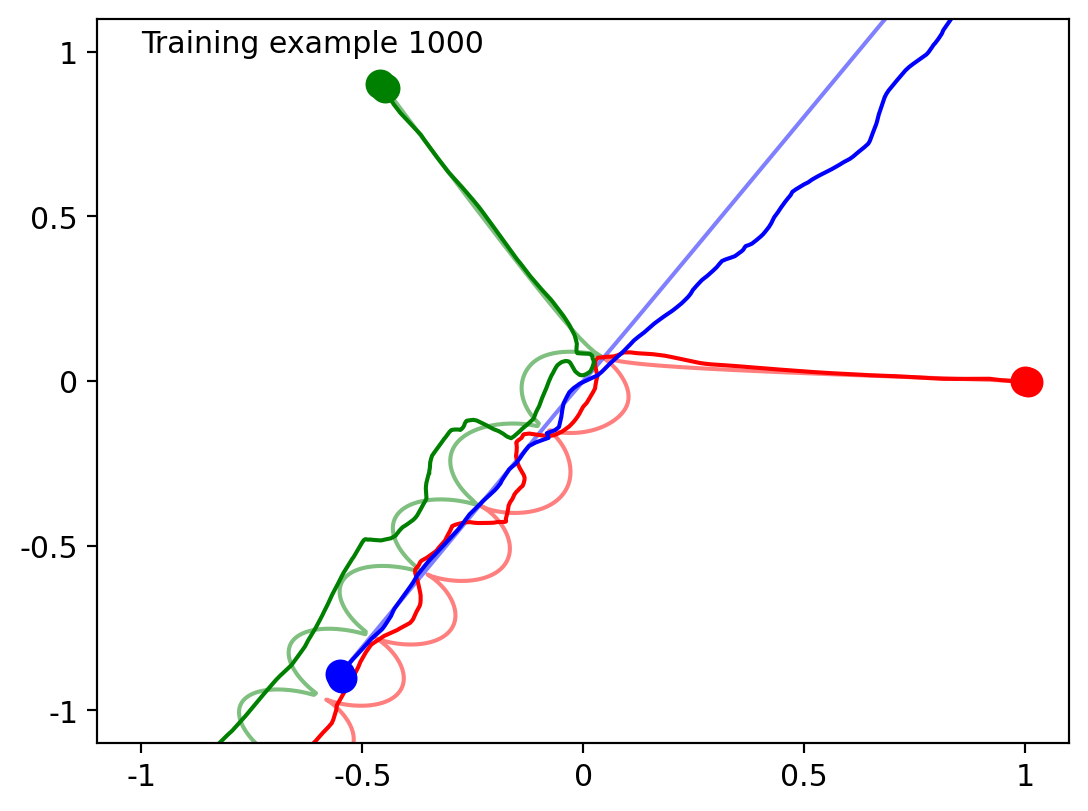

In [36]:
idx = 1000
input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
yhat_Eloss = model_Eloss.predict(input_data, verbose=False)

y_instance = y_train[idx,:,:]

p1_hat, p2_hat, p3_hat = get_trajectories(yhat_Eloss)
p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))

# Plot once for ground truth: y
plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx);

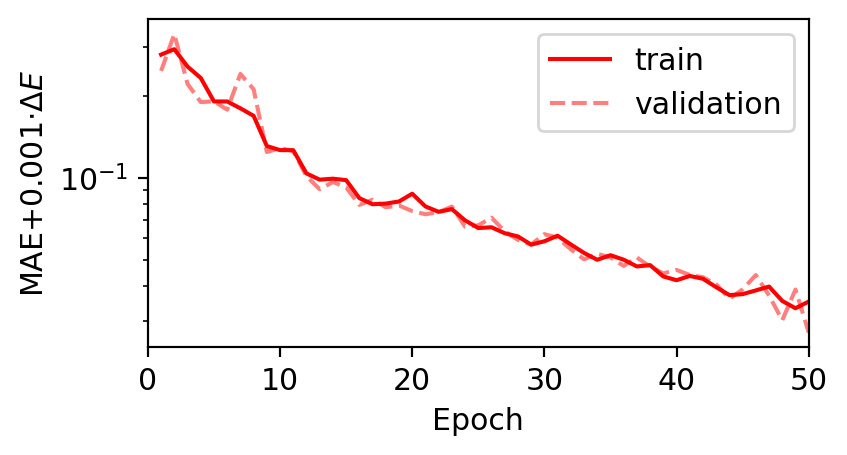

In [38]:
# generate synthetic data
if trainE:
    train_loss = list(history_Eloss.history["loss"])
    validation_loss = list(history_Eloss.history["val_loss"])
else:
    train_loss = np.load(f'./history/train_{model_name}.npy')
    validation_loss = np.load(f'./history/val_{model_name}.npy')

# --- plot

fig, ax = plt.subplots(1,1, figsize=(0.65*latex_textwidth, 0.65*latex_textwidth/2))

xepochs = np.arange(1,len(train_loss)+1,1)

ax.plot(xepochs, train_loss, color="red", ls="-", label="train")
ax.plot(xepochs, validation_loss, color="red", ls="--", alpha=0.5, label="validation")
ax.set_xlim([1,len(train_loss)])
ax.set_xticks(np.arange(0,len(train_loss)+2,(len(train_loss))/5))
ax.set_ylabel(r"MAE+0.001$\cdot\Delta{E}$")
ax.set_xlabel("Epoch")
# ax.set_title("Learning curve of ANN")
ax.set_yscale('log')
ax.legend()

fig.savefig("./plots/learning_curve_Eloss.png", bbox_inches='tight', dpi=400)

plt.show()

NameError: name 'instances' is not defined

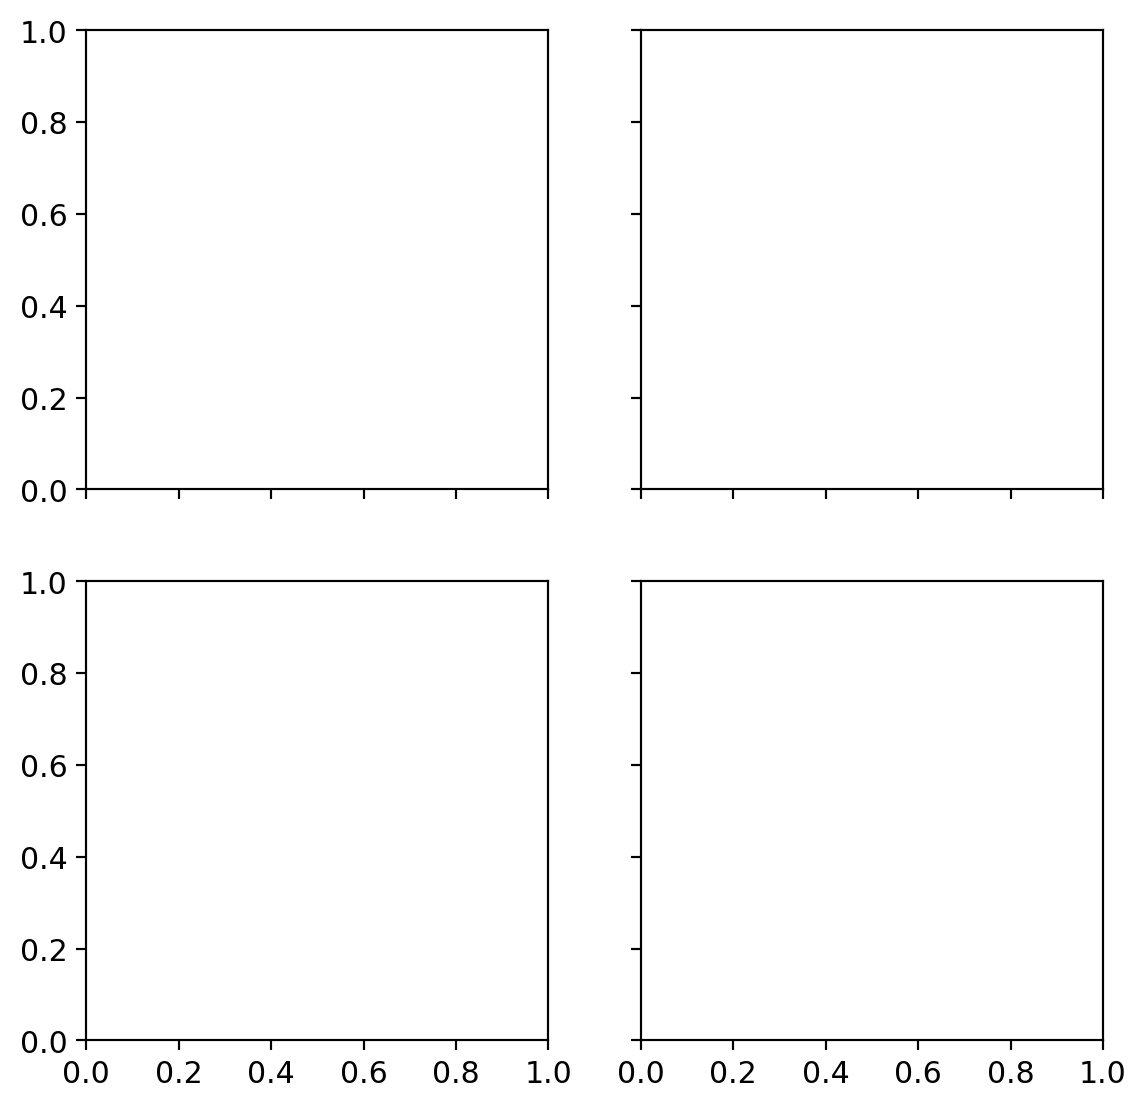

In [39]:

for mm, title in zip([model, model_Eloss], ["Our Model", "Our Model incl. Energy error"]):
    fig, axs = plt.subplots(2,2, figsize=(latex_textwidth,latex_textwidth), sharex=True, sharey=True)
    for idx, ax, settype in zip(instances, axs.flatten(), ["train", "validation", "train", "validation"]):
        if settype=="train":
            input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
            ax.annotate(f"Training example {idx}", xy=(-1, 1))
            y_instance = y_train[idx,:,:]
        elif settype=="validation": 
            input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
            ax.annotate(f"Validation example {idx}", xy=(-1, 1))
            y_instance = y_validation[idx,:,:]
    
        yhat = mm.predict(input_data, verbose=False)
    
        p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)
    
        plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx)
        plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
    # fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    if title != "Our model":
        fig.savefig("./plots/trajectory_Eloss.png", dpi=400)

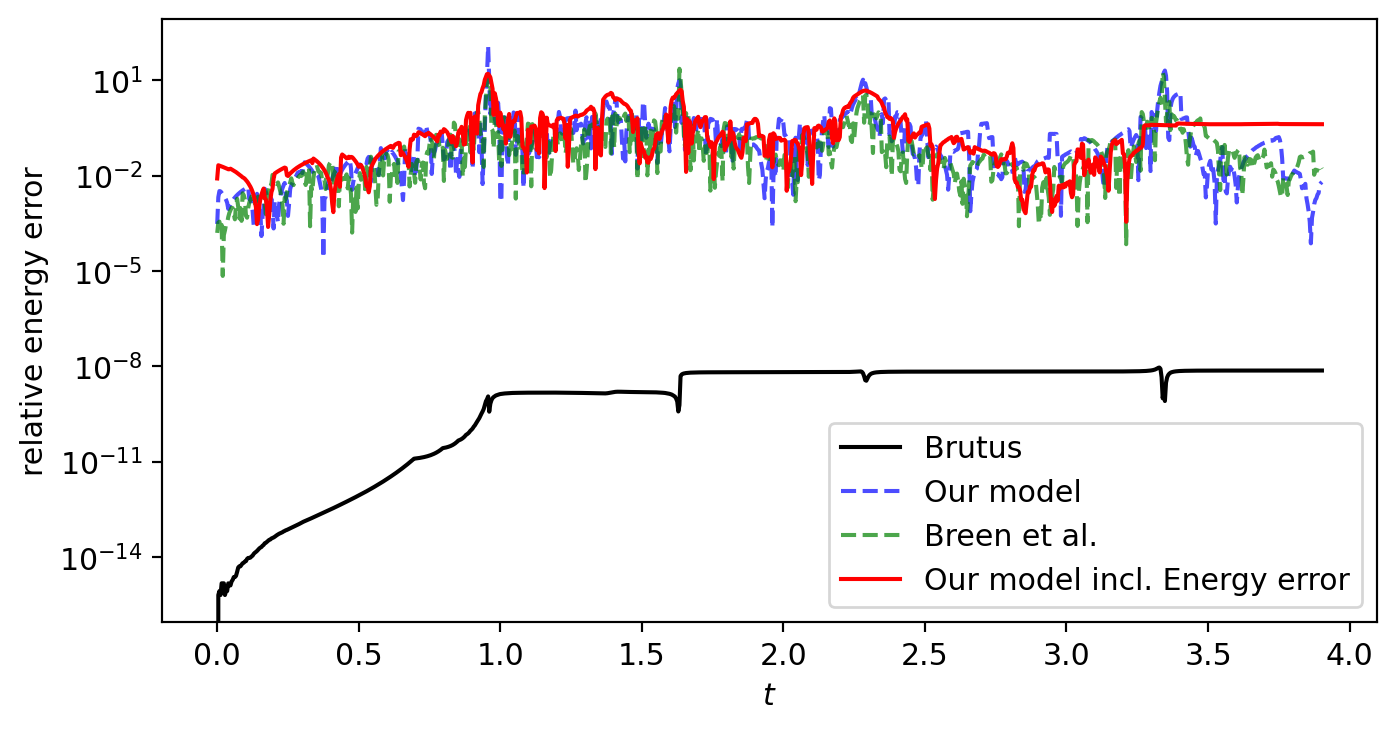

In [45]:
idx = 2347

input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))

v_Brutus = y_v_train[idx] # velocity data for the first two particles from Brutus for that trajectory
v_particle3 = tf.stack([-(v_Brutus[:,0]+v_Brutus[:,2]), -(v_Brutus[:,1]+v_Brutus[:,3])], axis=1) # velocity of the third particle
v_data = tf.stack([v_Brutus[:,0:2], v_Brutus[:,2:], v_particle3], axis=0) # concatenation of the velocities such that the shape matches the shape of predicted_velocities


y_Brutus = y_train[idx]
y_model = model.predict(input_data, verbose=False)
y_pre_trained = pre_trained_model.predict(input_data, verbose=False)
y_Eloss = model_Eloss.predict(input_data, verbose=False)

fig, ax = plt.subplots(figsize=(8,4))

base_energy = tf.abs(tf_compute_potential_energy(*get_trajectories(y_Brutus)))[0]

for y, label in zip([y_Brutus, y_model, y_pre_trained, y_Eloss], ["Brutus", "Our model", "Breen et al.", "Our model incl. Energy error"]):
    # if label != "Brutus":
    #     continue
    base_energy_loop = tf.cast(base_energy, y.dtype)
    
    t = tf.convert_to_tensor(np.linspace(X_train[0,0,0], X_train[0,-1,0], X_train[0,:,0].size).reshape(-1,1), dtype = y.dtype)
    predicted_positions = get_trajectories(y) # Obtained from y_pred
    predicted_velocities = tf_compute_velocities(t, predicted_positions) # Obtained from predicted_positions, tlist

    if label == "Brutus":
        ke_predicted_trajectory = tf_compute_kinetic_energy(v_data)
    else:
        ke_predicted_trajectory = tf_compute_kinetic_energy(predicted_velocities) # Obtained from predicted_velocities
    pe_predicted_trajectory = tf_compute_potential_energy(*predicted_positions) # Obtained from predicted_positions


    rel_energy_error = tf.abs(tf.abs(ke_predicted_trajectory + pe_predicted_trajectory) -
                     base_energy_loop) / base_energy_loop
    if label == "Brutus":
        ax.plot(t[::1], rel_energy_error[::1], ls='-', c='black', label=label)
    elif label == "Our model":
        ax.plot(t[::1], rel_energy_error[::1], ls='--', c='b', alpha=0.7, label=label)
    elif label == "Breen et al.":
        ax.plot(t[::1], rel_energy_error[::1], ls='--', c='g', alpha=0.7, label=label)
    else:
        ax.plot(t[::1], rel_energy_error[::1], ls='-', c='r', label=label)
ax.set_yscale('log')
ax.set_xlabel("$t$")
ax.set_ylabel("relative energy error")
ax.legend()
fig.savefig("./plots/energy_error.png", dpi=400)